# 投资组合 Portfolio

## 准备代码 Prepare 

In [1]:
import numpy as np # 数据处理最重要的模块
import pandas as pd # 数据处理最重要的模块
import scipy.stats as stats # 统计模块
import scipy
# import pymysql  # 导入数据库模块

from datetime import datetime # 时间模块
import statsmodels.formula.api as smf  # OLS regression

# import pyreadr # read RDS file

from matplotlib import style
import matplotlib.pyplot as plt  # 画图模块
import matplotlib.dates as mdates

from matplotlib.font_manager import FontProperties # 作图中文
from pylab import mpl
#mpl.rcParams['font.sans-serif'] = ['SimHei']
#plt.rcParams['font.family'] = 'Times New Roman'

#输出矢量图 渲染矢量图
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

from IPython.core.interactiveshell import InteractiveShell # jupyter运行输出的模块
#显示每一个运行结果
InteractiveShell.ast_node_interactivity = 'all'

#设置行不限制数量
#pd.set_option('display.max_rows',None)

#设置列不限制数量
pd.set_option('display.max_columns', None)

## 投资组合的构造方法

这一节，我们主要关注的问题是在个股层面。换句话说，就是我们能否预测个股的收益率。从计量层面上来说，就是是否能够找到某个指标能够在横截面预测个股的超额收益率（大家注意，以后我们如果不特别说明和产生歧义的情况下，收益率都表示的是减去无风险利率的超额收益率 excess return）。

那么，问题是，我们怎么去寻找这样的指标呢，哪些指标能够预测股票的超额收益率呢，预测的能力或者结果如何呢，这些都是我们要去思考以及数据处理的工作。

那么，标准的预测收益率的方法啊是使用构造投资组合的方法，使用零成本投资的策略，检验是否在此条件下仍然能够获得收益率。

* 指标的选取：理论？实务？
* 避免前视偏误（look ahead bias）

### 细节 Details

具体而言

* 我们要使用$t-1$月的指标对股票进行分组（一般分为10组），在不同的分组中，计算组内股票$t$月的加权平均收益率（或者简单平均收益率）
* 使用分组中最低组和最高组的差作为我们的投资组合，例如我们买入最高组的股票同时卖空最低组的股票（或者买入最低组卖空最高组，这个视指标和下一期收益率关系而定），这样我们自己的成本是零，但是我们可以通过这样的零成本，获得很高的收益
* 一般，我们将这种策略和大盘（市场）收益率进行对比，或者是Fama三因子、五因子等标准的定价因子对比。

在策略构造过程中，却有很多数据处理上的技术难题。

In [2]:
cross = pd.read_csv('datasets/ret_mon_python2023.csv')
from pandas.tseries.offsets import MonthEnd
cross['month'] = pd.to_datetime(cross['month'], format='%Y-%m-%d') + MonthEnd(1)
# 补齐股票代码 如果不满6位 在前面补上0
cross['Stkcd'] = cross['Stkcd'].apply(lambda x: '{:0>6}'.format(x)) # 6位股票代码
cross['w'] = 1
cross = cross.dropna(subset=['ret'])
cross


,Stkcd,month,price,Rank,Freq,floatingvalue,totalvalue,sizef,sizet,Return,rfmonth,ret,next_ret,w
1,000001,1991-05-31,38.34,2,24.0,1.016010e+09,1.859497e+09,20.739149,21.343572,-0.122253,0.006092,-0.128345,-0.119551,1
2,000001,1991-06-30,33.99,3,23.0,9.007350e+08,1.648521e+09,20.618722,21.223144,-0.113459,0.006092,-0.119551,-0.137013,1
3,000001,1991-07-31,29.54,4,16.0,7.828100e+08,1.432695e+09,20.478401,21.082823,-0.130921,0.006092,-0.137013,-0.417680,1
4,000001,1991-08-31,15.00,5,15.0,6.748338e+08,1.346275e+09,20.329977,21.020607,-0.411588,0.006092,-0.417680,-0.039425,1
5,000001,1991-09-30,14.50,6,24.0,6.523394e+08,1.301399e+09,20.296075,20.986706,-0.033333,0.006092,-0.039425,0.849080,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
752023,605599,2023-08-31,13.56,24,23.0,7.955351e+09,1.054667e+10,22.797111,23.079076,-0.025862,0.001241,-0.027103,0.071030,1
752024,605599,2023-09-30,14.54,25,20.0,8.530295e+09,1.130889e+10,22.866890,23.148855,0.072271,0.001241,0.071030,-0.048696,1
752025,605599,2023-10-31,13.85,26,17.0,8.125488e+09,1.077222e+10,22.818272,23.100237,-0.047455,0.001241,-0.048696,-0.027956,1
752026,605599,2023-11-30,13.48,27,22.0,7.908417e+09,1.048444e+10,22.791193,23.073159,-0.026715,0.001241,-0.027956,0.103358,1


## 数据细节
- floatingvalue 为股票的月末流通市值
- totalvalue 为股票月末的总市值
- Return 为股票该月的考虑红利的收益率
- rfmonth 为该月的无风险收益率
- Rank 为该公司上市的第几个月份
- Freq 为该股票在该月的交易天数
- ret = Return - rfmonth
- next_ret 为该股票下一个月的ret
- sizef 为floatingvalue的自然对数
- sizet 为totalvalue的自然对数
- ew 为1

## 策略细节

In [3]:
fenweishu = pd.DataFrame(
    cross.groupby(['month'])['ret'].quantile([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]))
fenweishu

ret
month                   
1991-01-31 0.1 -0.002031
           0.2  0.002868
           0.3  0.006672
           0.4  0.010476
           0.5  0.022318
...                  ...
2023-12-31 0.5 -0.030481
           0.6 -0.019060
           0.7 -0.003987
           0.8  0.016061
           0.9  0.058594

[3564 rows x 1 columns]

In [4]:
fenweishu = fenweishu.reset_index()
fenweishu

,month,level_1,ret
0,1991-01-31,0.1,-0.002031
1,1991-01-31,0.2,0.002868
2,1991-01-31,0.3,0.006672
3,1991-01-31,0.4,0.010476
4,1991-01-31,0.5,0.022318
...,...,...,...
3559,2023-12-31,0.5,-0.030481
3560,2023-12-31,0.6,-0.019060
3561,2023-12-31,0.7,-0.003987
3562,2023-12-31,0.8,0.016061


In [5]:
fenweishu = fenweishu.pivot_table(index='month',columns='level_1',values='ret')
fenweishu

level_1,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
month,,,,,,,,,
1991-01-31,-0.002031,0.002868,0.006672,0.010476,0.022318,0.034159,0.044819,0.055479,0.068586
1991-02-28,-0.042360,-0.037753,-0.012489,0.005470,0.019315,0.030097,0.034615,0.046888,0.081973
1991-03-31,-0.133314,-0.133261,-0.127661,-0.092379,-0.069797,-0.065144,-0.054707,-0.030694,0.028608
1991-04-30,-0.124371,-0.122867,-0.109328,-0.100079,-0.087628,-0.046745,0.020729,0.073833,0.090508
1991-05-31,-0.129118,-0.128345,-0.120582,-0.036993,-0.031989,-0.006657,0.055289,0.080639,0.202117
...,...,...,...,...,...,...,...,...,...
2023-08-31,-0.127963,-0.101104,-0.081604,-0.067501,-0.053251,-0.037892,-0.019222,0.004010,0.046254
2023-09-30,-0.077841,-0.048326,-0.030102,-0.016111,-0.004367,0.005559,0.017018,0.033242,0.066314
2023-10-31,-0.104815,-0.070334,-0.049764,-0.033905,-0.020315,-0.006363,0.010970,0.035557,0.078925


In [6]:
# Don't run
# fenweishu = fenweishu.reset_index()
# fenweishu

In [7]:
# Don't run
# 打印数据表列名
# fenweishu.columns

In [8]:
# Don't run
# fenweishu 表格宽变长
# fenweishu = fenweishu.melt(id_vars=['month'],value_vars=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])
# fenweishu

In [9]:
fenweishu.columns = ['one','two','three','four','five','six','seven','eight','nine']
fenweishu

,one,two,three,four,five,six,seven,eight,nine
month,,,,,,,,,
1991-01-31,-0.002031,0.002868,0.006672,0.010476,0.022318,0.034159,0.044819,0.055479,0.068586
1991-02-28,-0.042360,-0.037753,-0.012489,0.005470,0.019315,0.030097,0.034615,0.046888,0.081973
1991-03-31,-0.133314,-0.133261,-0.127661,-0.092379,-0.069797,-0.065144,-0.054707,-0.030694,0.028608
1991-04-30,-0.124371,-0.122867,-0.109328,-0.100079,-0.087628,-0.046745,0.020729,0.073833,0.090508
1991-05-31,-0.129118,-0.128345,-0.120582,-0.036993,-0.031989,-0.006657,0.055289,0.080639,0.202117
...,...,...,...,...,...,...,...,...,...
2023-08-31,-0.127963,-0.101104,-0.081604,-0.067501,-0.053251,-0.037892,-0.019222,0.004010,0.046254
2023-09-30,-0.077841,-0.048326,-0.030102,-0.016111,-0.004367,0.005559,0.017018,0.033242,0.066314
2023-10-31,-0.104815,-0.070334,-0.049764,-0.033905,-0.020315,-0.006363,0.010970,0.035557,0.078925


In [10]:
portfolio = pd.merge(cross,fenweishu,on='month',how='left')
portfolio

,Stkcd,month,price,Rank,Freq,floatingvalue,totalvalue,sizef,sizet,Return,rfmonth,ret,next_ret,w,one,two,three,four,five,six,seven,eight,nine
0,000001,1991-05-31,38.34,2,24.0,1.016010e+09,1.859497e+09,20.739149,21.343572,-0.122253,0.006092,-0.128345,-0.119551,1,-0.129118,-0.128345,-0.120582,-0.036993,-0.031989,-0.006657,0.055289,0.080639,0.202117
1,000001,1991-06-30,33.99,3,23.0,9.007350e+08,1.648521e+09,20.618722,21.223144,-0.113459,0.006092,-0.119551,-0.137013,1,-0.309901,-0.119551,-0.115097,0.166237,0.177858,0.184748,0.190006,0.190283,0.201980
2,000001,1991-07-31,29.54,4,16.0,7.828100e+08,1.432695e+09,20.478401,21.082823,-0.130921,0.006092,-0.137013,-0.417680,1,-0.244184,-0.128701,-0.086966,-0.052277,0.007620,0.067451,0.149691,0.216426,0.246553
3,000001,1991-08-31,15.00,5,15.0,6.748338e+08,1.346275e+09,20.329977,21.020607,-0.411588,0.006092,-0.417680,-0.039425,1,-0.161430,-0.110028,-0.049934,-0.014296,0.018298,0.060859,0.219168,0.233226,0.238218
4,000001,1991-09-30,14.50,6,24.0,6.523394e+08,1.301399e+09,20.296075,20.986706,-0.033333,0.006092,-0.039425,0.849080,1,-0.118675,-0.067377,-0.053691,-0.041891,-0.030783,-0.018184,0.055164,0.175783,0.190067
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
709878,605599,2023-08-31,13.56,24,23.0,7.955351e+09,1.054667e+10,22.797111,23.079076,-0.025862,0.001241,-0.027103,0.071030,1,-0.127963,-0.101104,-0.081604,-0.067501,-0.053251,-0.037892,-0.019222,0.004010,0.046254
709879,605599,2023-09-30,14.54,25,20.0,8.530295e+09,1.130889e+10,22.866890,23.148855,0.072271,0.001241,0.071030,-0.048696,1,-0.077841,-0.048326,-0.030102,-0.016111,-0.004367,0.005559,0.017018,0.033242,0.066314
709880,605599,2023-10-31,13.85,26,17.0,8.125488e+09,1.077222e+10,22.818272,23.100237,-0.047455,0.001241,-0.048696,-0.027956,1,-0.104815,-0.070334,-0.049764,-0.033905,-0.020315,-0.006363,0.010970,0.035557,0.078925
709881,605599,2023-11-30,13.48,27,22.0,7.908417e+09,1.048444e+10,22.791193,23.073159,-0.026715,0.001241,-0.027956,0.103358,1,-0.050131,-0.024692,-0.007101,0.006883,0.020630,0.034527,0.050795,0.075465,0.123638


In [11]:
portfolio['sort'] = np.where(
    portfolio['ret'] <= portfolio['one'], 'P1',
    np.where(
        portfolio['ret'] <= portfolio['two'], 'P2',
        np.where(
            portfolio['ret'] <= portfolio['three'], 'P3',
            np.where(
                portfolio['ret'] <= portfolio['four'], 'P4',
                np.where(
                    portfolio['ret'] <= portfolio['five'], 'P5',
                    np.where(
                        portfolio['ret'] <= portfolio['six'], 'P6',
                        np.where(
                            portfolio['ret'] <= portfolio['seven'], 'P7',
                            np.where(
                                portfolio['ret'] <= portfolio['eight'], 'P8',
                                np.where(
                                    portfolio['ret'] <= portfolio['nine'],
                                    'P9', 'Pmax')))))))))
portfolio

,Stkcd,month,price,Rank,Freq,floatingvalue,totalvalue,sizef,sizet,Return,rfmonth,ret,next_ret,w,one,two,three,four,five,six,seven,eight,nine,sort
0,000001,1991-05-31,38.34,2,24.0,1.016010e+09,1.859497e+09,20.739149,21.343572,-0.122253,0.006092,-0.128345,-0.119551,1,-0.129118,-0.128345,-0.120582,-0.036993,-0.031989,-0.006657,0.055289,0.080639,0.202117,P2
1,000001,1991-06-30,33.99,3,23.0,9.007350e+08,1.648521e+09,20.618722,21.223144,-0.113459,0.006092,-0.119551,-0.137013,1,-0.309901,-0.119551,-0.115097,0.166237,0.177858,0.184748,0.190006,0.190283,0.201980,P2
2,000001,1991-07-31,29.54,4,16.0,7.828100e+08,1.432695e+09,20.478401,21.082823,-0.130921,0.006092,-0.137013,-0.417680,1,-0.244184,-0.128701,-0.086966,-0.052277,0.007620,0.067451,0.149691,0.216426,0.246553,P2
3,000001,1991-08-31,15.00,5,15.0,6.748338e+08,1.346275e+09,20.329977,21.020607,-0.411588,0.006092,-0.417680,-0.039425,1,-0.161430,-0.110028,-0.049934,-0.014296,0.018298,0.060859,0.219168,0.233226,0.238218,P1
4,000001,1991-09-30,14.50,6,24.0,6.523394e+08,1.301399e+09,20.296075,20.986706,-0.033333,0.006092,-0.039425,0.849080,1,-0.118675,-0.067377,-0.053691,-0.041891,-0.030783,-0.018184,0.055164,0.175783,0.190067,P5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
709878,605599,2023-08-31,13.56,24,23.0,7.955351e+09,1.054667e+10,22.797111,23.079076,-0.025862,0.001241,-0.027103,0.071030,1,-0.127963,-0.101104,-0.081604,-0.067501,-0.053251,-0.037892,-0.019222,0.004010,0.046254,P7
709879,605599,2023-09-30,14.54,25,20.0,8.530295e+09,1.130889e+10,22.866890,23.148855,0.072271,0.001241,0.071030,-0.048696,1,-0.077841,-0.048326,-0.030102,-0.016111,-0.004367,0.005559,0.017018,0.033242,0.066314,Pmax
709880,605599,2023-10-31,13.85,26,17.0,8.125488e+09,1.077222e+10,22.818272,23.100237,-0.047455,0.001241,-0.048696,-0.027956,1,-0.104815,-0.070334,-0.049764,-0.033905,-0.020315,-0.006363,0.010970,0.035557,0.078925,P4
709881,605599,2023-11-30,13.48,27,22.0,7.908417e+09,1.048444e+10,22.791193,23.073159,-0.026715,0.001241,-0.027956,0.103358,1,-0.050131,-0.024692,-0.007101,0.006883,0.020630,0.034527,0.050795,0.075465,0.123638,P2


In [12]:
portfolio = portfolio.dropna(subset=['next_ret','floatingvalue'])
portfolio

,Stkcd,month,price,Rank,Freq,floatingvalue,totalvalue,sizef,sizet,Return,rfmonth,ret,next_ret,w,one,two,three,four,five,six,seven,eight,nine,sort
0,000001,1991-05-31,38.34,2,24.0,1.016010e+09,1.859497e+09,20.739149,21.343572,-0.122253,0.006092,-0.128345,-0.119551,1,-0.129118,-0.128345,-0.120582,-0.036993,-0.031989,-0.006657,0.055289,0.080639,0.202117,P2
1,000001,1991-06-30,33.99,3,23.0,9.007350e+08,1.648521e+09,20.618722,21.223144,-0.113459,0.006092,-0.119551,-0.137013,1,-0.309901,-0.119551,-0.115097,0.166237,0.177858,0.184748,0.190006,0.190283,0.201980,P2
2,000001,1991-07-31,29.54,4,16.0,7.828100e+08,1.432695e+09,20.478401,21.082823,-0.130921,0.006092,-0.137013,-0.417680,1,-0.244184,-0.128701,-0.086966,-0.052277,0.007620,0.067451,0.149691,0.216426,0.246553,P2
3,000001,1991-08-31,15.00,5,15.0,6.748338e+08,1.346275e+09,20.329977,21.020607,-0.411588,0.006092,-0.417680,-0.039425,1,-0.161430,-0.110028,-0.049934,-0.014296,0.018298,0.060859,0.219168,0.233226,0.238218,P1
4,000001,1991-09-30,14.50,6,24.0,6.523394e+08,1.301399e+09,20.296075,20.986706,-0.033333,0.006092,-0.039425,0.849080,1,-0.118675,-0.067377,-0.053691,-0.041891,-0.030783,-0.018184,0.055164,0.175783,0.190067,P5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
709877,605599,2023-07-31,13.92,23,21.0,8.166555e+09,1.082667e+10,22.823313,23.105278,0.053747,0.001241,0.052506,-0.027103,1,-0.109131,-0.061730,-0.031833,-0.004677,0.018420,0.038359,0.058412,0.084426,0.130416,P7
709878,605599,2023-08-31,13.56,24,23.0,7.955351e+09,1.054667e+10,22.797111,23.079076,-0.025862,0.001241,-0.027103,0.071030,1,-0.127963,-0.101104,-0.081604,-0.067501,-0.053251,-0.037892,-0.019222,0.004010,0.046254,P7
709879,605599,2023-09-30,14.54,25,20.0,8.530295e+09,1.130889e+10,22.866890,23.148855,0.072271,0.001241,0.071030,-0.048696,1,-0.077841,-0.048326,-0.030102,-0.016111,-0.004367,0.005559,0.017018,0.033242,0.066314,Pmax
709880,605599,2023-10-31,13.85,26,17.0,8.125488e+09,1.077222e+10,22.818272,23.100237,-0.047455,0.001241,-0.048696,-0.027956,1,-0.104815,-0.070334,-0.049764,-0.033905,-0.020315,-0.006363,0.010970,0.035557,0.078925,P4


In [13]:
portfolio_mom =  pd.DataFrame(
    portfolio.groupby(['month','sort']).apply(lambda x: np.average(x['next_ret'],weights = x['floatingvalue']),include_groups=False))
portfolio_mom

0
month      sort          
1991-01-31 P1   -0.041567
           P2    0.010496
           P4    0.038284
           P6    0.081305
           P8    0.028134
...                   ...
2023-11-30 P6   -0.012190
           P7   -0.023572
           P8   -0.026295
           P9    0.005428
           Pmax -0.050056

[3946 rows x 1 columns]

In [14]:
portfolio_mom = portfolio_mom.reset_index()
portfolio_mom.columns = ['month', 'sort', 'p']
portfolio_mom

,month,sort,p
0,1991-01-31,P1,-0.041567
1,1991-01-31,P2,0.010496
2,1991-01-31,P4,0.038284
3,1991-01-31,P6,0.081305
4,1991-01-31,P8,0.028134
...,...,...,...
3941,2023-11-30,P6,-0.012190
3942,2023-11-30,P7,-0.023572
3943,2023-11-30,P8,-0.026295
3944,2023-11-30,P9,0.005428


In [15]:
# Month plus one month 
portfolio_mom['month'] = portfolio_mom['month'] + MonthEnd(1)
# drop NA
portfolio_mom = portfolio_mom.dropna()
portfolio_mom

,month,sort,p
0,1991-02-28,P1,-0.041567
1,1991-02-28,P2,0.010496
2,1991-02-28,P4,0.038284
3,1991-02-28,P6,0.081305
4,1991-02-28,P8,0.028134
...,...,...,...
3941,2023-12-31,P6,-0.012190
3942,2023-12-31,P7,-0.023572
3943,2023-12-31,P8,-0.026295
3944,2023-12-31,P9,0.005428


In [16]:
portfolio_mom = portfolio_mom.pivot_table(index='month',
                                                    columns='sort',
                                                    values='p')
# long lowest return stocks and short highest return stocks
# 每个月持有最低换手率的10%股票，卖空最高换手率的10%股票
portfolio_mom['My_portfolio'] = portfolio_mom['P1'] - portfolio_mom['Pmax']
portfolio_mom

sort,P1,P2,P3,P4,P5,P6,P7,P8,P9,Pmax,My_portfolio
month,,,,,,,,,,,
1991-02-28,-0.041567,0.010496,NaN,0.038284,NaN,0.081305,NaN,0.028134,NaN,-0.002070,-0.039497
1991-03-31,-0.133253,-0.069140,-0.133293,0.023904,-0.125264,0.070941,-0.133504,-0.044343,-0.070455,-0.059149,-0.074104
1991-04-30,-0.122736,-0.123391,-0.103582,-0.077512,-0.133193,-0.000595,0.070484,-0.097744,0.120035,0.087227,-0.209963
1991-05-31,-0.006657,-0.129118,-0.036993,-0.120582,-0.130814,-0.031989,0.080639,0.055289,0.202117,0.238572,-0.245229
1991-06-30,-0.093032,-0.119551,-0.460637,-0.309901,0.190006,0.177858,0.213185,0.190283,0.166237,0.201980,-0.295012
...,...,...,...,...,...,...,...,...,...,...,...
2023-08-31,-0.048515,-0.047374,-0.049198,-0.064861,-0.052590,-0.056458,-0.054358,-0.052533,-0.059833,-0.069041,0.020526
2023-09-30,-0.013215,-0.008910,-0.008950,0.000798,0.000158,0.002106,0.001202,-0.024952,-0.007080,-0.012874,-0.000340
2023-10-31,-0.068257,-0.026400,-0.026712,-0.035206,-0.022298,-0.013751,-0.022298,-0.033380,-0.029932,0.008262,-0.076519


In [17]:
portfolio_mom = portfolio_mom['1995-01':'2023-12']
portfolio_mom

sort,P1,P2,P3,P4,P5,P6,P7,P8,P9,Pmax,My_portfolio
month,,,,,,,,,,,
1995-01-31,-0.143969,-0.139371,-0.128901,-0.132544,-0.084432,-0.118210,-0.131838,-0.123069,-0.111262,-0.157786,0.013817
1995-02-28,-0.010840,-0.030192,-0.042875,-0.037765,-0.031218,-0.026602,-0.018380,-0.022285,-0.013878,-0.009832,-0.001007
1995-03-31,0.198174,0.169944,0.182721,0.150245,0.112770,0.082351,0.063229,0.061804,0.139265,0.100180,0.097993
1995-04-30,-0.111658,-0.122584,-0.090036,-0.114348,-0.136476,-0.114342,-0.121700,-0.108680,-0.110145,-0.110720,-0.000937
1995-05-31,0.093185,0.192082,0.175307,0.156098,0.193785,0.190821,0.100348,0.149286,0.218207,0.225629,-0.132443
...,...,...,...,...,...,...,...,...,...,...,...
2023-08-31,-0.048515,-0.047374,-0.049198,-0.064861,-0.052590,-0.056458,-0.054358,-0.052533,-0.059833,-0.069041,0.020526
2023-09-30,-0.013215,-0.008910,-0.008950,0.000798,0.000158,0.002106,0.001202,-0.024952,-0.007080,-0.012874,-0.000340
2023-10-31,-0.068257,-0.026400,-0.026712,-0.035206,-0.022298,-0.013751,-0.022298,-0.033380,-0.029932,0.008262,-0.076519


In [18]:
model_port = smf.ols('My_portfolio ~ 1',
                 data=portfolio_mom['2000-02':'2023-12']).fit(
                     cov_type='HAC', cov_kwds={'maxlags': 6})
print(model_port.summary())

                            OLS Regression Results                            
Dep. Variable:           My_portfolio   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Wed, 27 Nov 2024   Prob (F-statistic):                nan
Time:                        09:51:04   Log-Likelihood:                 368.99
No. Observations:                 287   AIC:                            -736.0
Df Residuals:                     286   BIC:                            -732.3
Df Model:                           0                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0094      0.004      2.527      0.0

In [19]:
data = pd.read_csv('datasets/000001.csv')
data['Day'] = pd.to_datetime(data['Day'],format='%Y/%m/%d')
data.set_index('Day', inplace = True)
data.sort_values(by = ['Day'],axis=0, ascending=True)
data_new = data['1995-01':'2024-09'].copy()
data_new['Close'] = pd.to_numeric(data_new['Close'])
data_new['Preclose'] = pd.to_numeric(data_new['Preclose'])
data_new['Raw_return'] = data_new['Close'] / data_new['Preclose'] - 1
Month_data = data_new.resample('ME')['Raw_return'].apply(lambda x: (1+x).prod() - 1).to_frame()
Month_data.reset_index(inplace = True)
Month_data.rename(columns = {'Day':'month'}, inplace = True)
Month_data.set_index('month', inplace = True)
Month_data

,Preclose,Open,Highest,Lowest,Close,Volume,Money
Day,,,,,,,
1990-12-19,,96.050,99.980,95.790,99.980,126000.00,4.940000e+05
1990-12-20,99.98,104.300,104.390,99.980,104.390,19700.00,8.400000e+04
1990-12-21,104.39,109.070,109.130,103.730,109.130,2800.00,1.600000e+04
1990-12-24,109.13,113.570,114.550,109.130,114.550,3200.00,3.100000e+04
1990-12-25,114.55,120.090,120.250,114.550,120.250,1500.00,6.000000e+03
...,...,...,...,...,...,...,...
2024-09-24,2748.918,2770.754,2863.152,2761.372,2863.126,4776195.45,4.427953e+07
2024-09-25,2863.126,2901.419,2952.451,2889.048,2896.306,5682598.16,5.166981e+07
2024-09-26,2896.306,2893.745,3000.953,2889.014,3000.953,5763192.61,5.246691e+07


,Raw_return
month,
1995-01-31,-0.131631
1995-02-28,-0.023694
1995-03-31,0.177803
1995-04-30,-0.103552
1995-05-31,0.207922
...,...
2024-05-31,-0.005801
2024-06-30,-0.038684
2024-07-31,-0.009656


In [20]:
MYPOR = portfolio_mom[['P1','Pmax','My_portfolio']]
MYPOR = MYPOR.dropna()
MYPOR = pd.merge(MYPOR,Month_data,left_index=True,right_index=True,how='left')
MYPOR['month'] = pd.date_range(start = '1995',periods=len(MYPOR),freq = 'ME')
MYPOR.set_index('month', inplace = True)
MYPOR

,P1,Pmax,My_portfolio,Raw_return
month,,,,
1995-01-31,-0.143969,-0.157786,0.013817,-0.131631
1995-02-28,-0.010840,-0.009832,-0.001007,-0.023694
1995-03-31,0.198174,0.100180,0.097993,0.177803
1995-04-30,-0.111658,-0.110720,-0.000937,-0.103552
1995-05-31,0.093185,0.225629,-0.132443,0.207922
...,...,...,...,...
2023-08-31,-0.048515,-0.069041,0.020526,-0.052009
2023-09-30,-0.013215,-0.012874,-0.000340,-0.003013
2023-10-31,-0.068257,0.008262,-0.076519,-0.029483


In [21]:
model_port = smf.ols('My_portfolio ~ Raw_return',
                 data=MYPOR['2000-01':'2023-12']).fit(
                     cov_type='HAC', cov_kwds={'maxlags': 6})
print(model_port.summary())

                            OLS Regression Results                            
Dep. Variable:           My_portfolio   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     1.134
Date:                Wed, 27 Nov 2024   Prob (F-statistic):              0.288
Time:                        09:51:04   Log-Likelihood:                 369.66
No. Observations:                 288   AIC:                            -735.3
Df Residuals:                     286   BIC:                            -728.0
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0094      0.003      2.712      0.0

# 结果解读
这表示该策略有$\alpha$平均每个月0.94%，该策略没有显著的$\beta$。

In [22]:
# 计算投资组合的Sharpe Ratio
sharpe_ratio = MYPOR['My_portfolio'].mean() / MYPOR['My_portfolio'].std() * np.sqrt(12)
print(f"Sharpe Ratio: {sharpe_ratio}")

Sharpe Ratio: 0.22681459286006345


In [23]:
# 还原投资策略的价格
MYPOR['price_portfolio'] = (1 + MYPOR['My_portfolio']).cumprod()
MYPOR['price_p1'] = (1 + MYPOR['P1']).cumprod()
MYPOR['price_pmax'] = (1 + MYPOR['Pmax']).cumprod()
MYPOR['price_market'] = (1 + MYPOR['Raw_return']).cumprod()
MYPOR

,P1,Pmax,My_portfolio,Raw_return,price_portfolio,price_p1,price_pmax,price_market
month,,,,,,,,
1995-01-31,-0.143969,-0.157786,0.013817,-0.131631,1.013817,0.856031,0.842214,0.868369
1995-02-28,-0.010840,-0.009832,-0.001007,-0.023694,1.012795,0.846751,0.833933,0.847794
1995-03-31,0.198174,0.100180,0.097993,0.177803,1.112042,1.014555,0.917477,0.998534
1995-04-30,-0.111658,-0.110720,-0.000937,-0.103552,1.111000,0.901272,0.815894,0.895133
1995-05-31,0.093185,0.225629,-0.132443,0.207922,0.963855,0.985258,0.999983,1.081251
...,...,...,...,...,...,...,...,...
2023-08-31,-0.048515,-0.069041,0.020526,-0.052009,2.185047,6.500157,1.049028,4.815596
2023-09-30,-0.013215,-0.012874,-0.000340,-0.003013,2.184304,6.414259,1.035523,4.801086
2023-10-31,-0.068257,0.008262,-0.076519,-0.029483,2.017164,5.976441,1.044078,4.659537


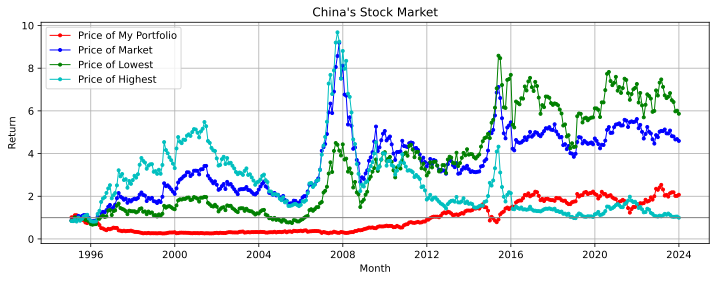

In [24]:
# 画图
fig = plt.figure(figsize=(12, 4))
plt.plot(
    'price_portfolio',  
    '.-r', 
    label='Price of My Portfolio',  
    linewidth=1, 
    data=MYPOR)  
plt.title("China's Stock Market") 
plt.xlabel('Month') 
plt.ylabel('Return') 

plt.plot(
    'price_market', 
    '.-b', 
    label='Price of Market', 
    linewidth=1, 
    data=MYPOR) 

plt.plot(
    'price_p1', 
    '.-g', 
    label='Price of Lowest', 
    linewidth=1, 
    data=MYPOR) 

plt.plot(
    'price_pmax', 
    '.-c', 
    label='Price of Highest', 
    linewidth=1, 
    data=MYPOR) 

# plot legend
plt.legend(loc='upper left')

# 添加网格线
plt.grid(True)

# 添加横线 1
plt.axhline(y=1, color='gray', linewidth=1)

plt.show();

In [25]:
# 计算累积收益率
MYPOR['cumulative_return'] = (1 + MYPOR['My_portfolio']).cumprod()

# 计算滚动最大值
MYPOR['rolling_max'] = MYPOR['cumulative_return'].cummax()

# 计算回撤
MYPOR['drawdown'] = MYPOR['cumulative_return'] / MYPOR['rolling_max'] - 1

# 计算最大回撤
max_drawdown = MYPOR['drawdown'].min()
print(f"Maximum Drawdown: {max_drawdown}")


Maximum Drawdown: -0.7687012364648881


In [26]:
# 找出最大回撤的时间
max_drawdown_end = MYPOR['drawdown'].idxmin() # 返回 Series 中最小值的索引
max_drawdown_start = MYPOR.loc[:max_drawdown_end, 'cumulative_return'].idxmax() # 这部分代码选择了从数据开始到 max_drawdown_end 时间点之间的所有累积收益率

print(f"Maximum Drawdown: {max_drawdown}")
print(f"Maximum Drawdown Start Date: {max_drawdown_start}")
print(f"Maximum Drawdown End Date: {max_drawdown_end}")

Maximum Drawdown: -0.7687012364648881
Maximum Drawdown Start Date: 1995-03-31 00:00:00
Maximum Drawdown End Date: 1999-05-31 00:00:00
